# PySpark - Machine Learning with ML Module

## Introduction

In the previous Project 4, the topics covered were from the MLlib Module, however this has be deprecated recently. Therefore in this project 5, the currently support machine learning module will be explored and is called the ML module. Similar to the MLlib, this ML module consists of a wide variety of machine learning models, with the exception that it operates on Spark DataFrames. This also means that it can leverage the tungsten execution optimisations. 

## Breakdown of this Notebook

- Transformers introduction
- Estimators introduction
- Pipelines introduction
- Selecting the most predictable features
- Predicting forest coverage types
- Estimating forest elevations
- Clustering forest cover types
- Tuning Hyperparameters
- Extracting features from text
- Discretising conitnuous variables
- Standardising continuous variables
- Topic Mining

## Dataset:

The dataset used for this project is the forest cover type dataset. It is used to predict the forest cover type from cartographic variables, meaning that there is no remote sensed data. The forest area included in this dataset are the four wilderness areas (Rawah (area 1), Neota (area 2), Comanche Peak (area 3), Cache la Poudre (area 4)) that is located in Roosevelt National Forest of Northern Colorado.

Source: https://archive.ics.uci.edu/ml/datasets/covertype or https://www.kaggle.com/uciml/forest-cover-type-dataset


## 1 PySpark Machine Configuration:

Here it only uses 4 processing cores from the CPU, and it set up by the following code.

In [1]:
%%configure
{
    "executorCores" : 4
}

In [2]:
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2 Setup the Correct Directory:

In [3]:
import os

# Change the Path:
path = '++++your working directory here++++/Datasets/'
os.chdir(path)
folder_pathway = os.getcwd()

# print(folder_pathway)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3 Load in the Dataset:

There should be a folder called "Datasets" included for the CSV file.

In [4]:
forest_dat = spark.read.csv(folder_pathway + '/Datasets/forest_covtype.csv', header = True, inferSchema = True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
forest_dat.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area1: integer (nullable = true)
 |-- Wilderness_Area2: integer (nullable = true)
 |-- Wilderness_Area3: integer (nullable = true)
 |-- Wilderness_Area4: integer (nullable = true)
 |-- Soil_Type1: integer (nullable = true)
 |-- Soil_Type2: integer (nullable = true)
 |-- Soil_Type3: integer (nullable = true)
 |-- Soil_Type4: integer (nullable = true)
 |-- Soil_Type5: integer (nullable = true)
 |-- Soil_Type6: integer (nullable = true)
 |-- Soil_Type7: integer

## 4 Transformers introduction:

A Transformer performs a transform() method that converts one DataFrame into another, usually appending a single or more columns. It is also an abstraction that includes feature transformaers and learned models.

- A feature transformer will take a DataFrame, read a column (like text), and then map it into a new column (feature vectors), once done, it will output a new DataFrame with the mapped column appended.

- A learning model will take a DataFrame, read the feature vectors column, predict the label for each feature vector, and then it will output a new DataFrame with predicted label results appended as a column.

Source: https://spark.apache.org/docs/1.6.0/ml-guide.html#transformers and https://spark.apache.org/docs/1.6.0/ml-features.html

### The following diagram shows a list of other types of Transformers that is able to convert one feature to another:

Image source -> https://spark.apache.org/docs/2.2.0/ml-features.html


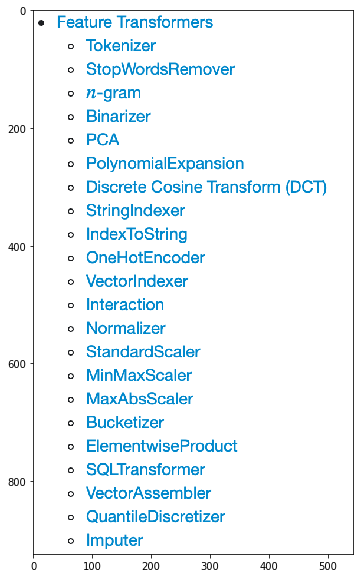

In [6]:
%%local

# Import the required library and set to use ggplot:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder_pathway = os.getcwd()
# print(folder_pathway)
image_path = folder_pathway + "/Description Images/"

# plot the image
fig, ax1 = plt.subplots(figsize=(16,10))
image = mpimg.imread(image_path + 'Spark Transformer types.png')
plt.imshow(image);

print('Image source -> https://spark.apache.org/docs/2.2.0/ml-features.html')

### In this section, the Bucketizer and VectorAssembler will be explored.

## 4.1 Bucketiser:

This will transform the "Horizontal_Distance_To_Hydrology" column into 10 equidistant buckets. The Horizontal_Distance_To_Hydrology column is quantitative, measured in meters and can be described as the __Horizontal Distance to nearest surface water features__.

Bucketizer uses a list of thresholds to transform a continuous numerical variable into a discrete one (with as many levels as the length of the list of thresholds plus one).

To do this:
- First, load in the required packages.
- Next, bucketise the numerical variables into 10 buckets.
- Calculate the minimum and maximum values for the "Horizontal_Distance_To_Hydrology" feature and it will return these 2 values to the driver node. 
- When on the driver, a list of thresholds is created that takes in 3 parameters. The first parameter is np.arrange() is the minimum, the second is the maximum and the last one is the size of each step. This should define the "splits" list.
- Pass the splits list to the .Bucketizer() method. 
- Lastly, the bucketizer object will transform the DataFrame accordingly.

In [7]:
# Import the required package:
import pyspark.sql.functions as f
import pyspark.ml.feature as feat
import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Define the number of numerical variables to bucketise:
buckets_nb = 10

# Calculate the min and max values of "Horizontal_Distance_To_Hydrology" feature:
dist_minMax = (
    forest_dat.agg(
        f.min('Horizontal_Distance_To_Hydrology').alias('min'),
        f.max('Horizontal_Distance_To_Hydrology').alias('max')
    )
    .rdd
    .map(lambda row: (row.min, row.max))
    .collect()[0]
)

# Calc the range between max and min distance:
rng_dist = dist_minMax[1] - dist_minMax[0]

# Create a Splits Lists:
splits_list = list(np.arange(
    dist_minMax[0],
    dist_minMax[1],
    rng_dist / (buckets_nb + 1)
))

# Using the Split list for the Bucketiser method:
bucketiser = feat.Bucketizer(
    splits = splits_list,
    inputCol = 'Horizontal_Distance_To_Hydrology',
    outputCol = 'Horizontal_Distance_To_Hydrology_Bkt'
)

# Transform the DataFrame:
(
    bucketiser
    .transform(forest_dat)
    .select('Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology_Bkt')
    .show(5)
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+------------------------------------+
|Horizontal_Distance_To_Hydrology|Horizontal_Distance_To_Hydrology_Bkt|
+--------------------------------+------------------------------------+
|                             258|                                 2.0|
|                             212|                                 1.0|
|                             268|                                 2.0|
|                             242|                                 1.0|
|                             153|                                 1.0|
+--------------------------------+------------------------------------+
only showing top 5 rows

## 4.2 VectorAssembler:

This section will combine multiple columns into a single column, then be used for PCA to find the principal components from the dataset. This will reduce the dimensionality/complexity as well.

The VectorAssembler collates multiple columns of features into a single column or in other words, it combines the specified (separate) features into a single feature. Unlike other Transformers, it has the inputCols (with an "s") parameter that accepts a list of columns rather than a single column.

To do this:
- Use the .VectorAssembler() to collate all of the columns from the dataFrame.
- Extract the top 5 most significatn principal components by using the "feat" column ( new a SparseVector containing all the features) in the PCA() method.

In [9]:
# Instantise the VectorAssembler and input the dataset for collation of the columns:
vectorAssembler = (
    feat.VectorAssembler(inputCols = forest_dat.columns, outputCol = 'feat')
)

# Perform PCA:
nb_PC = 5

pca_dat = (
    feat.PCA(k = nb_PC, inputCol = vectorAssembler.getOutputCol(), outputCol = 'pca_feat')
)

# Fit and transfrom the dataset with the calculated PCA mapping:
(
    pca_dat
    .fit(vectorAssembler.transform(forest_dat))
    .transform(vectorAssembler.transform(forest_dat))
    .select('feat', 'pca_feat')
    .take(1)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(feat=SparseVector(55, {0: 2596.0, 1: 51.0, 2: 3.0, 3: 258.0, 5: 510.0, 6: 221.0, 7: 232.0, 8: 148.0, 9: 6279.0, 10: 1.0, 42: 1.0, 54: 5.0}), pca_feat=DenseVector([-3887.7711, 4996.8103, 2323.0932, 1014.5873, -135.1702]))]

## 5 Estimators introduction:

Estimators can be described as an abstraction of a learning algorithm (or any algorithm) that will fit/train on the dataset. More specifically, an Estimator that implements a fit() method that accepts a DataFrame to produce a Model. This Model is a Transformer. For example, for Logistic Regression where it is an Estimator and that calling fit() method will train the LogisticRegressionModel, where it is a Model and hence a Transformer.

Source: https://spark.apache.org/docs/1.6.0/ml-guide.html#estimators, https://spark.apache.org/docs/1.6.0/ml-classification-regression.html and https://spark.apache.org/docs/1.6.0/ml-clustering.html


### The following diagrams shows a list of other types of Estimators (Machine Learning Models):

#### For Classification and Regression models:

Image source -> https://spark.apache.org/docs/1.6.0/ml-classification-regression.html


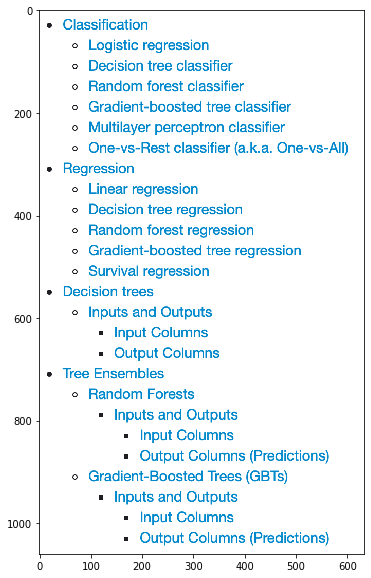

In [10]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 10))
image = mpimg.imread(image_path + 'Spark Estimator types_1.png')
plt.imshow(image);

print('Image source -> https://spark.apache.org/docs/1.6.0/ml-classification-regression.html')

#### For Clustering models:

Image source -> https://spark.apache.org/docs/1.6.0/ml-clustering.html


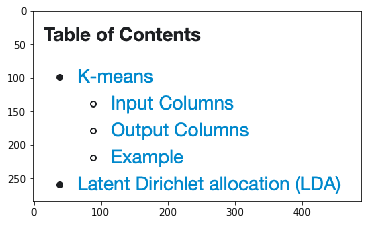

In [11]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 3.5))
image = mpimg.imread(image_path + 'Spark Estimator types_2.png')
plt.imshow(image);

print('Image source -> https://spark.apache.org/docs/1.6.0/ml-clustering.html')

## 5.1 Estimator Type: Support Vector Machine (SVM)

This section will explore on building a SVM model.

To do this:
- First, load in the necessary libraries.
- Next, use the .VectorAssembler() method to extract all the columns from the dataFrame, except for the last column that is the "CoverType" which will be the __Label__.
    - The label here is the "Spruce-fir" type which is equal to 1 in the dataset. 
    - To find these values, check whether the "Cover_Type" == 1 and casting the resulting Boolean as an Integer.
- Next, select the label and features.
- Next, create a LinearSVC object for the SVM model.
    - Specify the max iterations as 10,
    - Set it to have L2 (or Ridge) regularisation and to be 1%.
- Finally, use the .fit() method the SVM object on the dataset, and once completed, extract the estimated coefficients.

Other parameters can be:
- featuresCol, set as the name of the feature columns -> Default is "features"
- labelCol, set as the name of the label column
- predictionCol, set as the name of the prediction column, if there is a need to rename it to something else other than "prediction".
- tol, stopping parameter defining the minimum change between iterations in terms of the cost function. -> Default is "10^-6", if it is changed to a smaller value then it will be assumed to have converged.
- rawPredictionCol, returns the raw value from the generating function.
- fitIntercept, the model will fit the intercept as well -> Default is set to True.
- standardization, it standardises the features prior to fitting the model -> Default is set to True
- threshold, it decided what will be classified into either 1 or 0 -> Default is "0.0"
- weightCol, Each observation's column (set as Column names) will be weighted differently.
- aggregationDepth, this would be the tree-depth parameter used for the aggregation.

In [12]:
# Import the relevant libraries:
import pyspark.ml.classification as cl

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Collate the set of columns into a single feature column:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[0:-1],
    outputCol = 'features'
)

# Select only the Spruce-fir type to be the labels:
Spruce_fir_dat = (
    vectorAssembler
    .transform(forest_dat)
    .withColumn('label', (f.col('Cover_Type') == 1).cast('Integer') )
    .select('label', 'features')
)

# Instantise the SVM object:
svc_obj= cl.LinearSVC(maxIter = 10, regParam = 0.01)

# Fit the model to the dataset:
svc_model = svc_obj.fit(Spruce_fir_dat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Extract the estimated coefficients from the model:
svc_model.coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([-0.0001, -0.0, -0.0023, -0.0, -0.0001, 0.0, -0.001, -0.0017, -0.0003, -0.0, 0.0, 0.0401, -0.0071, -0.0958, -0.0901, -0.0653, -0.0655, -0.0437, -0.0928, -0.0848, -0.0211, -0.0045, -0.0498, -0.0829, -0.0522, -0.0325, -0.0263, -0.0923, -0.0889, -0.0275, -0.0606, -0.0595, 0.0341, -0.003, 0.0822, 0.0607, 0.0351, 0.0093, 0.0048, -0.0154, 0.0422, -0.0673, -0.0039, -0.0142, 0.0036, 0.0078, 0.0, -0.0117, 0.0283, -0.0002, -0.0463, 0.0394, 0.0292, 0.0358])

## 5.2 Estimator Type: Linear Regression

This section will explore on building a Linear Regression model. It has a similar set up to the above SVM model, however the Label used here is different. The Label chosen is the "Elevation" column and it will be cast as Float (for regression problems).

In [16]:
# Import the required Libraries:
import pyspark.ml.regression as rg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Collate the set of columns into a single feature column:
vectorAssembler = feat.VectorAssembler(
    inputCols = forest_dat.columns[1:],
    outputCol = 'features'
)

# Select only the label to be "Elevations":
elevation_dat = (
    vectorAssembler
    .transform(forest_dat)
    .withColumn('label', f.col('Elevation').cast('Float') )
    .select('label', 'features')
)

# Instantise the SVM object:
lr_obj= rg.LinearRegression( maxIter = 10, regParam = 0.01, elasticNetParam = 1.00 )

# Fit the model to the dataset:
lr_model = lr_obj.fit(elevation_dat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Extract the estimated coefficients from the model:
lr_model.coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([0.0309, 0.6522, 0.1911, 0.1424, 0.0342, 0.7402, 1.053, -0.0017, -0.0041, 2.7163, 189.0362, 27.8238, -265.8505, -407.4379, -346.0612, -364.3841, -302.6788, -400.5852, -212.9918, -126.1329, -117.7423, -312.0478, -248.7118, -221.4788, -155.1459, -84.5129, -398.0433, -387.8102, -179.4485, -261.3875, -337.7875, 48.0629, -94.7813, 149.8043, 135.144, 80.0901, 64.3659, 124.0233, -115.0126, 119.1285, -181.7498, 10.8056, -42.7849, 65.5441, 102.2562, 36.9865, -48.1163, 379.2091, 256.0169, 497.1714, 313.0607, 337.172, 397.0758, -14.4551])

### This Linear Regression model also calculates the summary which returns the basic performance statistics:

In [28]:
summary_lr = lr_model.summary

print(
    ' R-Squared: ' + str(round(summary_lr.r2, 4)) + '\n',
    'RMSE: ' + str(round(summary_lr.rootMeanSquaredError, 4)) + '\n',
    'MAE: ' + str(round(summary_lr.meanAbsoluteError, 4))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 R-Squared: 0.786
 RMSE: 129.5087
 MAE: 103.3408

### Observation:

By examining the R-Squared value of 78%, it indicates that 78% of all the variability of the data is around its mean meaning that the model is quite well fitted to the data. R-squared is a measure of how close the data are to the fitted regression line.

Source: https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

## 6 Pipelines Introduction:

